In [212]:
import pandas as pd 
import numpy as np 
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz 
from sklearn.model_selection import KFold
#import pydot
#cloned into https://github.com/erocarrera/pydot
#from pydot import dot_parser
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 


# Which types of companies are multi time donors? 

In [133]:
company = pd.read_csv("company_full.csv")
#company = company.drop("company", axis = 1)
company["multi_donor"] = 1 - company["one_donation"]
company = company.drop("one_donation", axis = 1)
food = pd.read_csv("no_isf_outliers")
food2 = pd.read_csv("no_ell_outliers")
food3 = pd.read_csv("no_outliers")

### Combining company types based on proportion 

In [134]:
company_food = company[company["type_food"] == 1]["multi_donor"]
company_other = company[company["type_other"] == 1]["multi_donor"]
company_comm = company[company["type_comm"] == 1]["multi_donor"]
company_fin = company[company["type_fin"] == 1]["multi_donor"]
company_soft = company[company["type_soft"] == 1]["multi_donor"]
company_bus = company[company["type_bus"] == 1]["multi_donor"]
company_eh = company[company["type_edu-health"] == 1]["multi_donor"]
company_applied = company[company["type_applied"] == 1]["multi_donor"]
company_web = company[company["type_web"] == 1]["multi_donor"]
company_sale = company[company["type_sale"] == 1]["multi_donor"]
dists_name = ["Food", "Other", "Communication", "Finance", "Software", 
             "Business", "Education-Health", "Applied", "Web", "Sale"]
dists = [company_food, company_other, company_comm, company_fin, company_soft,
        company_bus, company_eh, company_applied, company_web, company_sale]

In [135]:
import random
props = []
for i in range(len(dists)):
    dist = [sum(dists[i].sample(1000, replace = True))/1000 for j in range(1000)]
    props.append(sum(dist)/1000)
props = np.array(props)
print("Company Type and Proportions:")
for i in range(len(props)):
    print(food["type"].unique()[i], props[i])

Company Type and Proportions:
food 0.629799
other 0.647441
comm 0.57686
fin 0.703856
soft 0.812497
bus 0.709171
edu-health 0.571694
applied 0.545543
web 0.578588
sale 0.646239


In [136]:
for i in range(1, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[0]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Food and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(2, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[1]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Other and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(3, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[2]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Communication and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(4, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[3]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Finance and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(5, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[4]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Software and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(6, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[5]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Business and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(7, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[6]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Education-Health and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(8, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[7]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Applied and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))
for i in range(9, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[8]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("Web and " + dists_name[i] + ': {0:0.2f}'.format(
      1 - norm.cdf(abs(z))))

Food and Other: 0.21
Food and Communication: 0.01
Food and Finance: 0.00
Food and Software: 0.00
Food and Business: 0.00
Food and Education-Health: 0.00
Food and Applied: 0.00
Food and Web: 0.01
Food and Sale: 0.22
Other and Communication: 0.00
Other and Finance: 0.00
Other and Software: 0.00
Other and Business: 0.00
Other and Education-Health: 0.00
Other and Applied: 0.00
Other and Web: 0.00
Other and Sale: 0.48
Communication and Finance: 0.00
Communication and Software: 0.00
Communication and Business: 0.00
Communication and Education-Health: 0.41
Communication and Applied: 0.08
Communication and Web: 0.47
Communication and Sale: 0.00
Finance and Software: 0.00
Finance and Business: 0.40
Finance and Education-Health: 0.00
Finance and Applied: 0.00
Finance and Web: 0.00
Finance and Sale: 0.00
Software and Business: 0.00
Software and Education-Health: 0.00
Software and Applied: 0.00
Software and Web: 0.00
Software and Sale: 0.00
Business and Education-Health: 0.00
Business and Applied:

In [137]:
company["food_other_sale"] = company.iloc[:, [17, 18, 19]].sum(axis = 1)
company["comm_edu/health_web"] = company.iloc[:, [14, 15, 21]].sum(axis = 1)
company["fin_bus"] = company.iloc[:, [13, 16]].sum(axis = 1)
company = company.drop([ "type_food", "type_other", "type_sale", "type_comm", 
                       "type_edu-health", "type_web", "type_fin", "type_bus"], axis = 1)

### Combining company sizes based on proportions

In [138]:
company_10 = company[company["size_10.0"] == 1]["multi_donor"]
company_50 = company[company["size_50.0"] == 1]["multi_donor"]
company_200 = company[company["size_200.0"] == 1]["multi_donor"]
company_500 = company[company["size_500.0"] == 1]["multi_donor"]
company_1000 = company[company["size_1000.0"] == 1]["multi_donor"]
company_5000 = company[company["size_5000.0"] == 1]["multi_donor"]
company_10000 = company[company["size_10000.0"] == 1]["multi_donor"]
company_10001 = company[company["size_10001.0"] == 1]["multi_donor"]
dists_name = ["10", "50", "200", "500", "1000", 
             "5000", "10000", "10001"]
dists = [company_10, company_50, company_200, company_500, company_1000,
        company_5000, company_10000, company_10001]
import random
props = []
for i in range(len(dists)):
    dist = [sum(dists[i].sample(1000, replace = True))/1000 for j in range(1000)]
    props.append(sum(dist)/1000)
props = np.array(props)
print("Company Size and Proportions:")
for i in range(len(props)):
    print(dists_name[i] + ": ", props[i])

Company Size and Proportions:
10:  0.582649
50:  0.591822
200:  0.661586
500:  0.645813
1000:  0.899539
5000:  0.591087
10000:  0.49932
10001:  0.444822


In [139]:
for i in range(1, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[0]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("10 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(2, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[1]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("50 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(3, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[2]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("200 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(4, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[3]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("500 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(5, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[4]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("1000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(6, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[5]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("5000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))
for i in range(7, len(dists)): 
    n1 = 1000
    n2 = 1000
    p1 = props[6]
    p2 = props[i]
    p = (n1 * p1 + n2 * p2)/(n1 + n2)
    z = (p1 - p2)/(p * (1 - p) * (1/n1 + 1/n2))**0.5
    print("10000 and " + dists_name[i] + ': {0:0.2f}'.format(
     1 - norm.cdf(abs(z))))

10 and 50: 0.34
10 and 200: 0.00
10 and 500: 0.00
10 and 1000: 0.00
10 and 5000: 0.35
10 and 10000: 0.00
10 and 10001: 0.00
50 and 200: 0.00
50 and 500: 0.01
50 and 1000: 0.00
50 and 5000: 0.49
50 and 10000: 0.00
50 and 10001: 0.00
200 and 500: 0.23
200 and 1000: 0.00
200 and 5000: 0.00
200 and 10000: 0.00
200 and 10001: 0.00
500 and 1000: 0.00
500 and 5000: 0.01
500 and 10000: 0.00
500 and 10001: 0.00
1000 and 5000: 0.00
1000 and 10000: 0.00
1000 and 10001: 0.00
5000 and 10000: 0.00
5000 and 10001: 0.00
10000 and 10001: 0.01


In [140]:
company["size_10/50"] = company.iloc[:, [1, 6]].sum(axis = 1)
company["size_200/500"] = company.iloc[:, [5, 7]].sum(axis = 1)
company = company.drop(["size_10.0", "size_50.0", "size_200.0", "size_500.0"], axis = 1)

### Looking at whether a company would be a one time donor before their first donation

In [229]:
features = company.drop(["multi_donor", "company"], axis = 1) 
y = company["multi_donor"]
#features = pd.get_dummies(features)
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, y, test_size = 0.25, random_state = 23156)

#### Initial Random Forest with Default Settings

In [230]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.72
Precision Score: 0.74
Recall Score: 0.85
Testing Accuracy
Overall Accuracy: 0.69
Precision Score: 0.74
Recall Score: 0.83


In [232]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: state_underdeveloped Importance: 0.11
Variable: size_200/500         Importance: 0.1
Variable: state_New York       Importance: 0.09
Variable: size_10/50           Importance: 0.09
Variable: state_California     Importance: 0.08
Variable: comm_edu/health_web  Importance: 0.08
Variable: size_1000.0          Importance: 0.07
Variable: fin_bus              Importance: 0.07
Variable: size_5000.0          Importance: 0.06
Variable: type_applied         Importance: 0.06
Variable: food_other_sale      Importance: 0.06
Variable: size_10000.0         Importance: 0.04
Variable: size_10001.0         Importance: 0.04
Variable: type_soft            Importance: 0.04


In [49]:
#tree = rf.estimators_[5]
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
#graph.write_png('tree.png')
#pydot.dot_parser.parse_dot_data("tree.dot")

TypeError: must be str, not ParseException

#### Random Grid Search

In [13]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 60, num = 20)] 
#max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 12, num = 11)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)]
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, cv = 5, verbose = 2, random_state = 6819,
                              n_jobs = -1)
rf_random.fit(train_features, train_labels)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [143]:
rf = RandomForestClassifier(bootstrap = True,
                            max_depth = 3,
                            max_features = "sqrt",
                            min_samples_leaf = 1,
                            min_samples_split = 4,
                            n_estimators = 1000,
                            random_state = 12356)
rf.fit(train_features, train_labels);
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.66
Precision Score: 0.65
Recall Score: 0.98
Testing Accuracy
Overall Accuracy: 0.72
Precision Score: 0.73
Recall Score: 0.95


#### Grid Search CV 

In [1186]:
n_estimators = [int(x) for x in np.linspace(start = 800, stop = 1200, num = 5)]
max_features =  ["sqrt"]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 4, num = 4)] 
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]
min_samples_split =  [int(x) for x in np.linspace(start = 2, stop = 6, num = 5)]
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,
                          n_jobs = -1, verbose = 2) 
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 13.4min finished


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200}

#### Final RF model with best parameters 

In [144]:
rf = RandomForestClassifier(bootstrap = True,
                            max_depth = 3,
                            max_features = "auto",
                            min_samples_leaf = 1,
                            min_samples_split = 5,
                            n_estimators = 1200,
                            random_state = 12356)
rf.fit(train_features, train_labels);
overall_accuracy_train = sum(rf.predict(train_features) == train_labels)/len(train_labels)
precision_accuracy_train = precision_score(train_labels, rf.predict(train_features))
recall_accuracy_train = recall_score(train_labels, rf.predict(train_features))
overall_accuracy_test = sum(rf.predict(test_features) == test_labels)/len(test_labels)
precision_accuracy_test = precision_score(test_labels, rf.predict(test_features))
recall_accuracy_test = recall_score(test_labels, rf.predict(test_features))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.66
Precision Score: 0.65
Recall Score: 0.98
Testing Accuracy
Overall Accuracy: 0.72
Precision Score: 0.73
Recall Score: 0.95


In [ ]:
preds = rf.predict(test_features)
predicted_one_time = [i for i in range(len(preds)) if preds[i] == 1]
predicted_multi_time = [i for i in range(len(preds)) if preds[i] == 0]
true_one_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 1]
true_multi_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 0]
true_positives = len(np.intersect1d(predicted_one_time, true_one_time))
false_positives = len(np.intersect1d(predicted_one_time, true_multi_time))
true_negatives = len(np.intersect1d(predicted_multi_time, true_multi_time))
false_negatives = len(np.intersect1d(predicted_multi_time, true_one_time))
true_negatives

\begin{align*}
&- \text{The recall score drastically increased from the initial model from 0.83 to 0.95} \\
&- \text{Final model more likely to identify companies as multi donors than one time donors, precision of model not very accurate} \\ 
\end{align*}

In [1194]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: state_underdeveloped Importance: 0.2
Variable: size_1000.0          Importance: 0.14
Variable: size_10/50           Importance: 0.08
Variable: state_California     Importance: 0.07
Variable: state_New York       Importance: 0.07
Variable: size_200/500         Importance: 0.07
Variable: type_applied         Importance: 0.06
Variable: comm_edu/health_web  Importance: 0.06
Variable: fin_bus              Importance: 0.06
Variable: size_10001.0         Importance: 0.04
Variable: size_5000.0          Importance: 0.04
Variable: type_soft            Importance: 0.04
Variable: food_other_sale      Importance: 0.04
Variable: size_10000.0         Importance: 0.03


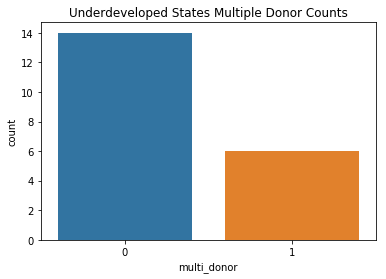

In [1320]:
sns.countplot(company[company["state_underdeveloped"] == 1]["multi_donor"]);
plt.title("Underdeveloped States Multiple Donor Counts");


In [1314]:
ud_len = company[company["state_underdeveloped"] == 1].shape[0]
ud_num_md = sum(company[company["state_underdeveloped"] == 1]["multi_donor"])
ca_len = company[company["state_California"] == 1].shape[0]
ca_num_md = sum(company[company["state_California"] == 1]["multi_donor"])
ny_len = company[company["state_New York"] == 1].shape[0]
ny_num_md = sum(company[company["state_New York"] == 1]["multi_donor"])
print("Underdeveloped multi-donor proportion: " + str(ud_num_md/ud_len))
print("California multi-donor proportion: " + str(ca_num_md/ca_len))
print("New York multi-donor proportion: " + str(ny_num_md/ny_len))

Underdeveloped multi-donor proportion: 0.3
California multi-donor proportion: 0.674074074074074
New York multi-donor proportion: 0.6551724137931034


\begin{align*}
&- \text{The feature with the highest importance (0.2) is state_underdeveloped and it seems that if a company is in a state that's not CA or NY, the company will likely be labeled as a one-time donor.} \\
&- \text{ Out of 20 companies that are in a state other than CA or NY, 6 of which donated more than once} \\
&- \text{Is Replate not as developed in states outside of CA and NY and that's why companies are not as likely to donate multiple times?} \\
\end{align*}

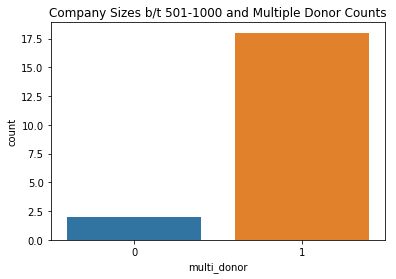

In [1321]:
sns.countplot(company[company["size_1000.0"] == 1]["multi_donor"]);
plt.title("Company Sizes b/t 501-1000 and Multiple Donor Counts");

\begin{align*}
&- \text{The next highest feature in terms of importance (0.14) is size_1000.} \\ 
&- \text{Out of 20 companies that have a size between 501-1000 employees, 18 of them have donated more than once}
\end{align*}

In [1318]:

s1000_len = company[company["size_1000.0"] == 1].shape[0]
s1000_num_md = sum(company[company["size_1000.0"] == 1]["multi_donor"])
s10000_len = company[company["size_10000.0"] == 1].shape[0]
s10000_num_md = sum(company[company["size_10000.0"] == 1]["multi_donor"])
s10001_len = company[company["size_10001.0"] == 1].shape[0]
s10001_num_md = sum(company[company["size_10001.0"] == 1]["multi_donor"])
s5000_len = company[company["size_5000.0"] == 1].shape[0]
s5000_num_md = sum(company[company["size_5000.0"] == 1]["multi_donor"])
s10_50_len = company[company["size_10/50"] == 1].shape[0]
s10_50_num_md = sum(company[company["size_10/50"] == 1]["multi_donor"])
s200_500_len = company[company["size_200/500"] == 1].shape[0]
s200_500_num_md = sum(company[company["size_200/500"] == 1]["multi_donor"])

print("Size 1-50 multi-donor proportion: " + str(s10_50_num_md/s10_50_len))
print("Size 51-500 multi-donor proportion: " + str(s200_500_num_md/s200_500_len))
print("Size 501-1000 multi-donor proportion: " + str(s1000_num_md/s1000_len))
print("Size 1001-5000 multi-donor proportion: " + str(s5000_num_md/s5000_len))
print("Size 5001-10000 multi-donor proportion: " + str(s10000_num_md/s10000_len))
print("Size 10001+ multi-donor proportion: " + str(s10001_num_md/s10001_len))

Size 1-50 multi-donor proportion: 0.5897435897435898
Size 51-500 multi-donor proportion: 0.6571428571428571
Size 501-1000 multi-donor proportion: 0.9
Size 1001-5000 multi-donor proportion: 0.5909090909090909
Size 5001-10000 multi-donor proportion: 0.5
Size 10001+ multi-donor proportion: 0.4444444444444444


\begin{align*}
&- \text{There doesn't seem to be a strong trend in whether a company wuld be a multi donor in the other sizes which is reflected in them having importances lower than 0.1} \\
&- \text{Seems that the proportion of multiple donors increases with size up until 1000 and then the proportion drops down.}
\end{align*}

In [1195]:
#tree = rf.estimators
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
#(graph, ) = graph_from_dot_file('tree.dot')
#graph.write_png('tree.png')
#dot_parser.parse_dot_data("tree.dot")

### Looking at whether a company would be a one time donor after donation 

In [178]:

def clean_food(x): 
    x = x.drop(["Unnamed: 0", "Unnamed: 0.1", "Id", "id", "number", "street", "city", 
                  "zip", "lat", "lon", "pickup", "planned", "month", "day", 
                  "year", "weekday"], axis = 1)
    x["date"] = pd.to_datetime(x["date"])
    x["size"] = x["size"].astype("str")
    x_num_donation = x.groupby("company")["company"].count()
    x_one_donation = (x_num_donation == 1).astype("int")
    x_size = x.groupby("company")["size"].first()
    x_type = x.groupby("company")["type"].first()
    x_state = x.groupby("company")["state"].first()
    x_last_donation_weeks = (np.max(x["date"]) - x.groupby("company")["date"].agg(np.max)).apply(lambda x: x.days)//7
    x_last_donation = x[x.groupby("company").date.transform("max") == x["date"]].groupby("company").first()["pounds"]
    company = pd.DataFrame({"multi_donor": 1 - x_one_donation,
                       "size": x_size, "type": x_type,
                       "state": x_state, 
                        "last_donation": x_last_donation,
                        "last_donation_weeks": x_last_donation_weeks,
                       })
    return pd.get_dummies(company)
company2 = clean_food(food)
company3 = clean_food(food2)
company4 = clean_food(food3)


In [179]:
def combine_size_type(x):
    x["food_other_sale"] = x.iloc[:, [19, 20, 21]].sum(axis = 1)
    x["comm_edu/health_web"] = x.iloc[:, [16, 17, 23]].sum(axis = 1)
    x["fin_bus"] = x.iloc[:, [18, 15]].sum(axis = 1)
    x = x.drop([ "type_food", "type_other", "type_sale", "type_comm", 
                       "type_edu-health", "type_web", "type_fin", "type_bus"], axis = 1)
    x["size_10/50"] = x.iloc[:, [3, 8]].sum(axis = 1)
    x["size_200/500"] = x.iloc[:, [7, 9]].sum(axis = 1)
    x = x.drop(["size_10.0", "size_50.0", "size_200.0", "size_500.0"], axis = 1)
    return x 
company2 = combine_size_type(company2)
company3 = combine_size_type(company3)
company4 = combine_size_type(company4)

In [180]:
features2 = company2.drop(["multi_donor"], axis = 1) 
y2 = company2["multi_donor"]
feature2_list = list(features2.columns)
features2 = np.array(features2)
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, y2, test_size = 0.25, random_state = 23156)

features3 = company3.drop(["multi_donor"], axis = 1) 
y3 = company3["multi_donor"]
feature3_list = list(features3.columns)
features3 = np.array(features3)
train_features3, test_features3, train_labels3, test_labels3 = train_test_split(features3, y3, test_size = 0.25, random_state = 23156)

features4 = company4.drop(["multi_donor"], axis = 1) 
y4 = company4["multi_donor"]
feature4_list = list(features4.columns)
features4 = np.array(features4)
train_features4, test_features4, train_labels4, test_labels4 = train_test_split(features4, y4, test_size = 0.25, random_state = 23156)


#### Initial Random Forest 

In [181]:
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 1.00
Precision Score: 1.00
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.64
Precision Score: 0.69
Recall Score: 0.80


In [182]:
rf3 = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 1.00
Precision Score: 1.00
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.58
Precision Score: 0.67
Recall Score: 0.71


In [183]:
rf4 = RandomForestClassifier(n_estimators = 1000, random_state = 12356)
rf4.fit(train_features4, train_labels4);
overall_accuracy_train = sum(rf4.predict(train_features4) == train_labels4)/len(train_labels4)
precision_accuracy_train = precision_score(train_labels4, rf4.predict(train_features4))
recall_accuracy_train = recall_score(train_labels4, rf4.predict(train_features4))
overall_accuracy = sum(rf4.predict(test_features4) == test_labels4)/len(test_labels4)
precision_accuracy = precision_score(test_labels4, rf4.predict(test_features4))
recall_accuracy = recall_score(test_labels4, rf4.predict(test_features4))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 1.00
Precision Score: 1.00
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.58
Precision Score: 0.67
Recall Score: 0.71


#### Random Grid Search

In [155]:
rf2 = RandomForestClassifier()
rf2_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 23456,
                              n_jobs = -1)
rf2_random.fit(train_features2, train_labels2)
rf2_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 24.3min finished


{'bootstrap': False,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 200}

In [185]:
rf2 = RandomForestClassifier(bootstrap = False,
                            max_depth = 3,
                            max_features = "sqrt",
                            min_samples_leaf = 1,
                            min_samples_split = 6,
                            n_estimators = 200,
                            random_state = 23456)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.75
Precision Score: 0.74
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.68
Precision Score: 0.67
Recall Score: 0.97


In [156]:
rf3 = RandomForestClassifier()
rf3_random = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 23456,
                              n_jobs = -1)
rf3_random.fit(train_features3, train_labels3)
rf3_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 25.0min finished


{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1800}

In [190]:
rf3 = RandomForestClassifier(bootstrap = True,
                            max_depth = 15,
                            max_features = "sqrt",
                            min_samples_leaf = 1,
                            min_samples_split = 5,
                            n_estimators = 1800,
                            random_state = 23456)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.96
Precision Score: 0.95
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.60
Precision Score: 0.69
Recall Score: 0.71


In [157]:
rf4 = RandomForestClassifier()
rf4_random = RandomizedSearchCV(estimator = rf4, param_distributions = random_grid,
                              n_iter = 500, cv = 5, verbose = 2, random_state = 23456,
                              n_jobs = -1)
rf4_random.fit(train_features4, train_labels4)
rf4_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 24.3min finished


{'bootstrap': True,
 'max_depth': 21,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [188]:
rf4 = RandomForestClassifier(bootstrap = True,
                            max_depth = 21,
                            max_features = "auto",
                            min_samples_leaf = 1,
                            min_samples_split = 5,
                            n_estimators = 600,
                            random_state = 23456)
rf4.fit(train_features4, train_labels4);
overall_accuracy_train = sum(rf4.predict(train_features4) == train_labels4)/len(train_labels4)
precision_accuracy_train = precision_score(train_labels4, rf4.predict(train_features4))
recall_accuracy_train = recall_score(train_labels4, rf4.predict(train_features4))
overall_accuracy = sum(rf4.predict(test_features4) == test_labels4)/len(test_labels4)
precision_accuracy = precision_score(test_labels4, rf4.predict(test_features4))
recall_accuracy = recall_score(test_labels4, rf4.predict(test_features4))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.96
Precision Score: 0.96
Recall Score: 0.99
Testing Accuracy
Overall Accuracy: 0.60
Precision Score: 0.69
Recall Score: 0.71


#### Grid Search CV

In [191]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_features = ["sqrt"]
max_depth = [1, 2, 3, 4, 5, 10] 
min_samples_leaf = [1, 2, 3, 4, 5, 10]
min_samples_split =  [4, 5, 6, 7, 8, 10]
from sklearn.model_selection import GridSearchCV
param_grid2 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [False]}
rf2 = RandomForestClassifier()
grid_search2 = GridSearchCV(estimator = rf2, param_grid = param_grid2, cv = 5,
                          n_jobs = -1, verbose = 2) 
grid_search2.fit(train_features2, train_labels2)
grid_search2.best_params_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 23.2min finished


{'bootstrap': False,
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [194]:
rf2 = RandomForestClassifier(bootstrap = False,
                            max_depth = 1,
                            max_features = "sqrt",
                            min_samples_leaf = 1,
                            min_samples_split = 4,
                            n_estimators = 100,
                            random_state = 23456)
rf2.fit(train_features2, train_labels2);
overall_accuracy_train = sum(rf2.predict(train_features2) == train_labels2)/len(train_labels2)
precision_accuracy_train = precision_score(train_labels2, rf2.predict(train_features2))
recall_accuracy_train = recall_score(train_labels2, rf2.predict(train_features2))
overall_accuracy_test = sum(rf2.predict(test_features2) == test_labels2)/len(test_labels2)
precision_accuracy_test = precision_score(test_labels2, rf2.predict(test_features2))
recall_accuracy_test = recall_score(test_labels2, rf2.predict(test_features2))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.70
Precision Score: 0.70
Recall Score: 1.00
Testing Accuracy
Overall Accuracy: 0.64
Precision Score: 0.64
Recall Score: 1.00


In [192]:
n_estimators = [1500, 1600, 1700, 1800, 1900, 2000]
max_features = ["sqrt"]
max_depth = [12, 13, 14, 15, 16, 17, 18, 20] 
min_samples_leaf = [1, 2, 3, 4, 5, 10]
min_samples_split =  [3, 4, 5, 6, 7, 10]
param_grid3 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]}
rf3 = RandomForestClassifier()
grid_search3 = GridSearchCV(estimator = rf3, param_grid = param_grid3, cv = 5,
                          n_jobs = -1, verbose = 2) 
grid_search3.fit(train_features3, train_labels3)
grid_search3.best_params_

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 83.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 101.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 111.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 122.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 140.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 165.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 186.0min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 203.1min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed: 213.4min finished


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1800}

In [195]:
rf3 = RandomForestClassifier(bootstrap = True,
                            max_depth = 12,
                            max_features = "sqrt",
                            min_samples_leaf = 1,
                            min_samples_split = 10,
                            n_estimators = 1800,
                            random_state = 23456)
rf3.fit(train_features3, train_labels3);
overall_accuracy_train = sum(rf3.predict(train_features3) == train_labels3)/len(train_labels3)
precision_accuracy_train = precision_score(train_labels3, rf3.predict(train_features3))
recall_accuracy_train = recall_score(train_labels3, rf3.predict(train_features3))
overall_accuracy_test = sum(rf3.predict(test_features3) == test_labels3)/len(test_labels3)
precision_accuracy_test = precision_score(test_labels3, rf3.predict(test_features3))
recall_accuracy_test = recall_score(test_labels3, rf3.predict(test_features3))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.90
Precision Score: 0.88
Recall Score: 0.98
Testing Accuracy
Overall Accuracy: 0.58
Precision Score: 0.67
Recall Score: 0.71


In [193]:
n_estimators = [400, 500, 600, 700, 800, 1000]
max_features = ["auto"]
max_depth = [15, 18, 19, 20, 21, 22, 23, 25] 
min_samples_leaf = [1, 2, 3, 5]
min_samples_split =  [3, 4, 5, 6, 8]
param_grid4 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]}
rf4 = RandomForestClassifier()
grid_search4 = GridSearchCV(estimator = rf4, param_grid = param_grid4, cv = 5,
                          n_jobs = -1, verbose = 2) 
grid_search4.fit(train_features4, train_labels4)
grid_search4.best_params_

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 152.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 156.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 160.7min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 164.9min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 600}

In [196]:
rf4 = RandomForestClassifier(bootstrap = True,
                            max_depth = 20,
                            max_features = "auto",
                            min_samples_leaf = 2,
                            min_samples_split = 3,
                            n_estimators = 600,
                            random_state = 23456)
rf4.fit(train_features4, train_labels4);
overall_accuracy_train = sum(rf4.predict(train_features4) == train_labels4)/len(train_labels4)
precision_accuracy_train = precision_score(train_labels4, rf4.predict(train_features4))
recall_accuracy_train = recall_score(train_labels4, rf4.predict(train_features4))
overall_accuracy = sum(rf4.predict(test_features4) == test_labels4)/len(test_labels4)
precision_accuracy = precision_score(test_labels4, rf4.predict(test_features4))
recall_accuracy = recall_score(test_labels4, rf4.predict(test_features4))

print("Training Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_train))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_train))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_train))
print("Testing Accuracy")
print("Overall Accuracy: {0:0.2f}". format( 
        overall_accuracy_test))
print('Precision Score: {0:0.2f}'.format(
      precision_accuracy_test))
print('Recall Score: {0:0.2f}'.format(
      recall_accuracy_test))

Training Accuracy
Overall Accuracy: 0.95
Precision Score: 0.94
Recall Score: 0.99
Testing Accuracy
Overall Accuracy: 0.58
Precision Score: 0.67
Recall Score: 0.71


#### Final RF model with best parameters

In [197]:
importances = list(rf2.feature_importances_)
feature2_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature2_list, importances)]
feature2_importances = sorted(feature2_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature2_importances];

Variable: last_donation_weeks  Importance: 0.31
Variable: size_10/50           Importance: 0.2
Variable: last_donation        Importance: 0.16
Variable: size_5000.0          Importance: 0.12
Variable: size_1000.0          Importance: 0.11
Variable: state_Underdeveloped Importance: 0.05
Variable: type_applied         Importance: 0.02
Variable: fin_bus              Importance: 0.02
Variable: size_200/500         Importance: 0.01
Variable: size_10000.0         Importance: 0.0
Variable: size_10001.0         Importance: 0.0
Variable: state_California     Importance: 0.0
Variable: state_New York       Importance: 0.0
Variable: type_soft            Importance: 0.0
Variable: food_other_sale      Importance: 0.0
Variable: comm_edu/health_web  Importance: 0.0


In [198]:
preds = rf2.predict(test_features2)
predicted_one_time = [i for i in range(len(preds)) if preds[i] == 1]
predicted_multi_time = [i for i in range(len(preds)) if preds[i] == 0]
true_one_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 1]
true_multi_time = [i for i in range(len(test_labels)) if np.array(test_labels)[i] == 0]
true_positives = len(np.intersect1d(predicted_one_time, true_one_time))
false_positives = len(np.intersect1d(predicted_one_time, true_multi_time))
true_negatives = len(np.intersect1d(predicted_multi_time, true_multi_time))
false_negatives = len(np.intersect1d(predicted_multi_time, true_one_time))

In [199]:
importances = list(rf3.feature_importances_)
feature3_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature3_list, importances)]
feature3_importances = sorted(feature3_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature3_importances];

Variable: last_donation_weeks  Importance: 0.46
Variable: last_donation        Importance: 0.19
Variable: state_Underdeveloped Importance: 0.06
Variable: size_10/50           Importance: 0.06
Variable: comm_edu/health_web  Importance: 0.03
Variable: size_200/500         Importance: 0.03
Variable: size_1000.0          Importance: 0.02
Variable: size_5000.0          Importance: 0.02
Variable: state_California     Importance: 0.02
Variable: state_New York       Importance: 0.02
Variable: type_applied         Importance: 0.02
Variable: food_other_sale      Importance: 0.02
Variable: fin_bus              Importance: 0.02
Variable: size_10000.0         Importance: 0.01
Variable: size_10001.0         Importance: 0.01
Variable: type_soft            Importance: 0.01


In [200]:
importances = list(rf4.feature_importances_)
feature4_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature4_list, importances)]
feature4_importances = sorted(feature4_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature4_importances];


Variable: last_donation_weeks  Importance: 0.51
Variable: last_donation        Importance: 0.21
Variable: state_New York       Importance: 0.04
Variable: size_200/500         Importance: 0.04
Variable: state_California     Importance: 0.03
Variable: type_applied         Importance: 0.03
Variable: food_other_sale      Importance: 0.03
Variable: size_10/50           Importance: 0.03
Variable: comm_edu/health_web  Importance: 0.02
Variable: fin_bus              Importance: 0.02
Variable: size_1000.0          Importance: 0.01
Variable: size_5000.0          Importance: 0.01
Variable: state_Underdeveloped Importance: 0.01
Variable: type_soft            Importance: 0.01
Variable: size_10000.0         Importance: 0.0
Variable: size_10001.0         Importance: 0.0


# Predicting how much food a company will donate

In [203]:
company_full = pd.read_csv("company_with_donation.csv")
#company_full["multi_donor"] = 1 - company_full["one_donation"]
#company_full = company_full.drop("one_donation", axis = 1)

In [204]:
company_full.columns

Index(['company', 'avg_donation', 'last_donation', 'last_donation_weeks',
       'min_donation', 'multi_donor', 'num_donation', 'num_weeks',
       'popular_month_frac', 'popular_weekday_frac', 'week_donation',
       'top_contributor', 'popular_month_1', 'popular_month_10',
       'popular_month_11', 'popular_month_12', 'popular_month_2',
       'popular_month_3', 'popular_month_4', 'popular_month_5',
       'popular_month_6', 'popular_month_7', 'popular_month_8',
       'popular_month_9', 'popular_weekday_Friday', 'popular_weekday_Monday',
       'popular_weekday_Thursday', 'popular_weekday_Tuesday',
       'popular_weekday_Wednesday', 'size_10.0', 'size_1000.0', 'size_10000.0',
       'size_10001.0', 'size_200.0', 'size_50.0', 'size_500.0', 'size_5000.0',
       'start_month_1', 'start_month_10', 'start_month_11', 'start_month_12',
       'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5',
       'start_month_6', 'start_month_7', 'start_month_8', 'start_month_9',
   

In [209]:
features = company_full.drop(["avg_donation", "company"], axis = 1) 
y = company_full["avg_donation"]
#features = pd.get_dummies(features)
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, y, test_size = 0.25, random_state = 23156)

Text(0,0.5,'explained_variance_')

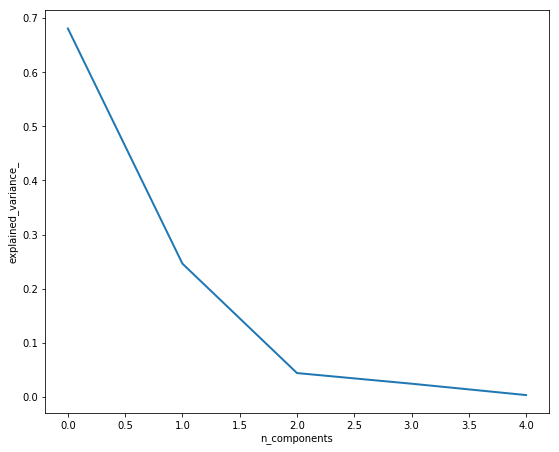

In [226]:
pca = PCA()
pca.fit(features)
plt.figure(1, figsize=(10, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_[0:5], linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')


Keep the first 3 principal components

In [222]:
pca.explained_variance_ratio_

array([  6.80456578e-01,   2.46203923e-01,   4.41414181e-02,
         2.44996598e-02,   3.51006282e-03,   1.12987574e-03,
         6.04100778e-06,   3.90741322e-06,   3.72977874e-06,
         3.11875464e-06,   2.69275036e-06,   2.42324062e-06,
         2.32976911e-06,   2.19032406e-06,   2.01740750e-06,
         1.79984972e-06,   1.76658217e-06,   1.68196914e-06,
         1.59628558e-06,   1.55156696e-06,   1.47093296e-06,
         1.45209246e-06,   1.32141655e-06,   1.28885917e-06,
         1.22984361e-06,   1.17790833e-06,   1.07799473e-06,
         9.62731242e-07,   9.17599813e-07,   8.89259456e-07,
         8.53123724e-07,   8.15740018e-07,   7.91489593e-07,
         7.03585414e-07,   6.63473591e-07,   6.24901912e-07,
         5.85975294e-07,   5.43422056e-07,   5.21580572e-07,
         4.28735951e-07,   4.07639461e-07,   3.92992169e-07,
         3.59863423e-07,   3.35997710e-07,   3.16441509e-07,
         2.93157612e-07,   2.63497769e-07,   2.42977734e-07,
         2.02171923e-07,

In [227]:
pca.components_

array([[  7.76556201e-01,  -1.82607911e-03,   6.06966648e-01, ...,
          5.15287524e-05,  -2.91337913e-05,  -5.84625532e-05],
       [  6.80096062e-02,  -2.92461476e-02,  -3.40200556e-01, ...,
         -9.44528898e-05,   7.66473102e-06,  -4.54470958e-05],
       [  5.39759871e-01,   1.21544369e-03,  -6.47654895e-01, ...,
          1.00906778e-04,   8.53864978e-05,  -1.95364118e-05],
       ..., 
       [  0.00000000e+00,  -4.68319918e-18,   1.31596424e-19, ...,
         -1.39086147e-01,  -1.39086147e-01,  -1.39086147e-01],
       [  0.00000000e+00,   5.96733055e-18,  -1.39692294e-19, ...,
          1.93026632e-01,   1.93026632e-01,   1.93026632e-01],
       [  0.00000000e+00,  -4.11537009e-17,  -2.40821866e-18, ...,
         -3.30242888e-04,  -3.30242888e-04,  -3.30242888e-04]])